### Load all disgenet GDA data
> all_gene_disease_associations.tsv can be obtained from https://www.disgenet.org/downloads

In [1]:
import pandas as pd

all_gda_df = pd.read_csv("all_gene_disease_associations.tsv", "\t")
all_gda_df.head()

/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.7,0.538,C0001418,Adenocarcinoma,group,C04,Neoplastic Process,0.01,1.0,2008.0,2008.0,1,0,LHGDN
1,1,A1BG,0.7,0.538,C0002736,Amyotrophic Lateral Sclerosis,disease,C18;C10,Disease or Syndrome,0.01,1.0,2008.0,2008.0,1,0,BEFREE
2,1,A1BG,0.7,0.538,C0003578,Apnea,phenotype,C23;C08,Sign or Symptom,0.01,1.0,2017.0,2017.0,1,0,BEFREE
3,1,A1BG,0.7,0.538,C0003864,Arthritis,disease,C05,Disease or Syndrome,0.01,1.0,2019.0,2019.0,1,0,BEFREE
4,1,A1BG,0.7,0.538,C0008373,Cholesteatoma,disease,C17,Disease or Syndrome,0.01,1.0,2020.0,2020.0,1,0,BEFREE


In [2]:
all_gda_df = all_gda_df[
    ["geneId", "geneSymbol", "DSI", "DPI", "score", "diseaseId", "diseaseName"]
]  # Get needed columns
all_gda_df.head()

,geneId,geneSymbol,DSI,DPI,score,diseaseId,diseaseName
0,1,A1BG,0.7,0.538,0.01,C0001418,Adenocarcinoma
1,1,A1BG,0.7,0.538,0.01,C0002736,Amyotrophic Lateral Sclerosis
2,1,A1BG,0.7,0.538,0.01,C0003578,Apnea
3,1,A1BG,0.7,0.538,0.01,C0003864,Arthritis
4,1,A1BG,0.7,0.538,0.01,C0008373,Cholesteatoma


In [3]:
all_gda_df.geneSymbol.nunique(), all_gda_df.diseaseId.nunique()

(21666, 30170)

### Create disease to disease_description mapping from MGDEF of DisGenNet
> MGDEF.csv can be obtained from https://ftp.ncbi.nlm.nih.gov/pub/medgen/

In [4]:
disease_def_df = pd.read_csv("MGDEF.csv")
disease_def_df.head()
disease_des_dict = {}
for _, item in all_gda_df.iterrows():
    disease_des_dict[item["diseaseId"]] = item[
        "diseaseName"
    ]  ## Default disease description is disease name
for _, item in disease_def_df.iterrows():
    disease_des_dict[item["CUI"]] = item["DEF"]

### Map CUI to Disease Description

In [5]:
all_gda_df["diseaseDes"] = all_gda_df["diseaseId"].map(lambda x: disease_des_dict[x])

In [6]:
# with open("gene_symbol.txt",'w') as f: # This is a gene_symbol use to retrieval in https://www.uniprot.org/uploadlists/
#     f.write(" ".join(all_gda_df['geneSymbol'].unique()))

### Create gene to gene_protein_seq mapping from STRING

In [7]:
prot_info_df = pd.read_csv("9606.protein.info.v11.5.txt", "\t")
prot_info_gene = prot_info_df["preferred_name"].unique()
prot_info_df["preferred_name"].nunique()

/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


19563

In [8]:
prot_info_df.head(3)

,#string_protein_id,preferred_name,protein_size,annotation
0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,9606.ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


In [9]:
# Check overlapping between all_gda_df and string
not_exist = []
exist_gene = []
for gene_name in all_gda_df["geneSymbol"].unique():
    if gene_name not in prot_info_gene:
        not_exist.append(gene_name)
    else:
        exist_gene.append(gene_name)
with open("gene_exist_in_STRING.txt", "w") as f:
    f.write(" ".join(exist_gene))
with open("gene_exist_NOT_in_STRING.txt", "w") as f:
    f.write(" ".join(not_exist))
len(not_exist), len(exist_gene)

(5756, 15910)

### Filter out all the association according to gene_exist_in_STRING.txt
> 9606.protein.sequences.v11.5.fa can be obtained from https://string-db.org/cgi/download?sessionId=bznr4eHEqnC5

In [10]:
print(f"the number of gda: {len(all_gda_df.index)}")

the number of gda: 1134942


In [11]:
all_gda_df_filtered = all_gda_df[
    all_gda_df.geneSymbol.isin(exist_gene)
]  ## Filter by exist_gene

In [12]:
# create protein to seqence mapping

with open("9606.protein.sequences.v11.5.fa") as f:
    lines = f.readlines()
    line_str = "".join(lines)
id_seq_str_list = line_str.split(">")
prot_id_to_seq = {}
for id_seq_str in id_seq_str_list:
    tokens = id_seq_str.split("\n")
    key = tokens[0]
    val = "".join(tokens[1:])
    prot_id_to_seq[key] = val

In [13]:
## Create gene to protein sequence mapping
gene_to_seq_dict = {}
no_seq_gene_list = (
    []
)  ## gene name and protein id cannot find in the prot String dataset
multi_seq_gene_list = (
    []
)  ## gene name and protein id cannot find in the prot String dataset

for _, item in prot_info_df.iterrows():
    gene_name = item["preferred_name"]
    if gene_name in exist_gene:
        protein_id = item["#string_protein_id"]
        gene_to_seq_dict[gene_name] = prot_id_to_seq[protein_id]
        if (gene_name in gene_to_seq_dict) and (
            prot_id_to_seq[protein_id] != gene_to_seq_dict[gene_name]
        ):
            multi_seq_gene_list.append(gene_name)
    else:
        no_seq_gene_list.append(gene_name)

In [14]:
len(no_seq_gene_list), len(multi_seq_gene_list)

(3656, 0)

In [15]:
final_gene_name_list = gene_to_seq_dict.keys()
all_gda_df_filtered = all_gda_df[all_gda_df.geneSymbol.isin(final_gene_name_list)]
len(gene_to_seq_dict)  ## Final gene to seq mapping

15910

In [16]:
# map gene to protein sequence
all_gda_df_filtered["proteinSeq"] = all_gda_df_filtered["geneSymbol"].apply(
    lambda x: gene_to_seq_dict[x]
)
all_gda_df_filtered

/tmp/ipykernel_101603/1325574237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_gda_df_filtered["proteinSeq"] = all_gda_df_filtered["geneSymbol"].apply(lambda x: gene_to_seq_dict[x])


,geneId,geneSymbol,DSI,DPI,score,diseaseId,diseaseName,diseaseDes,proteinSeq
0,1,A1BG,0.700,0.538,0.01,C0001418,Adenocarcinoma,A common cancer characterized by the presence ...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
1,1,A1BG,0.700,0.538,0.01,C0002736,Amyotrophic Lateral Sclerosis,A neurodegenerative disease characterized by p...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
2,1,A1BG,0.700,0.538,0.01,C0003578,Apnea,Lack of breathing with no movement of the resp...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
3,1,A1BG,0.700,0.538,0.01,C0003864,Arthritis,Inflammation of a joint.,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
4,1,A1BG,0.700,0.538,0.01,C0008373,Cholesteatoma,Cholesteatoma is a benign but potentially dest...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
...,...,...,...,...,...,...,...,...,...
1132776,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C0344395,Bilirubin measurement,Bilirubin measurement,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...
1132777,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C0410702,Adolescent idiopathic scoliosis,A scoliosis with no known cause arising in ado...,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...
1132778,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C0489786,Height,Height,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...
1132779,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C1287365,Bilirubin level result,Bilirubin level result,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...


In [17]:
all_gda_df_filtered.to_csv("disgenet_all.csv")

In [3]:
df_full = pd.read_csv("disgenet_all.csv")

In [26]:
def get_pair_idx(item, col1="geneId", col2="diseaseId"):
    pair_idx = str(item[col1]).strip() + "-" + item[col2].strip() 
    return pair_idx
df_full["pair_idx"] = df_full.apply(get_pair_idx, axis=1)

In [27]:
df_full

,Unnamed: 0,Unnamed: 0.1,geneId,geneSymbol,DSI,DPI,score,diseaseId,diseaseName,diseaseDes,proteinSeq,pair_idx
0,0,0,1,A1BG,0.700,0.538,0.01,C0001418,Adenocarcinoma,A common cancer characterized by the presence ...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,1-C0001418
1,1,1,1,A1BG,0.700,0.538,0.01,C0002736,Amyotrophic Lateral Sclerosis,A neurodegenerative disease characterized by p...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,1-C0002736
2,2,2,1,A1BG,0.700,0.538,0.01,C0003578,Apnea,Lack of breathing with no movement of the resp...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,1-C0003578
3,3,3,1,A1BG,0.700,0.538,0.01,C0003864,Arthritis,Inflammation of a joint.,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,1-C0003864
4,4,4,1,A1BG,0.700,0.538,0.01,C0008373,Cholesteatoma,Cholesteatoma is a benign but potentially dest...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,1-C0008373
...,...,...,...,...,...,...,...,...,...,...,...,...
1018350,1019922,1132776,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C0344395,Bilirubin measurement,Bilirubin measurement,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...,115072896-C0344395
1018351,1019923,1132777,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C0410702,Adolescent idiopathic scoliosis,A scoliosis with no known cause arising in ado...,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...,115072896-C0410702
1018352,1019924,1132778,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C0489786,Height,Height,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...,115072896-C0489786
1018353,1019925,1132779,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C1287365,Bilirubin level result,Bilirubin level result,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...,115072896-C1287365


In [29]:
import pandas as pd
def get_pair_idx(item, col1="ID1", col2="ID2"):
    pair_idx = str(item[col1]).strip() + "-" + item[col2].strip() 
    return pair_idx
df = pd.read_csv("disgenet.csv")
df["pair_idx"] = df.apply(get_pair_idx, axis=1)

In [32]:
df

,Unnamed: 0,ID1,X1,ID2,X2,Y,pair_idx
0,0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30,1-C0019209
1,1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30,1-C0036341
2,2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50,2-C0002395
3,3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31,2-C0007102
4,4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30,2-C0009375
...,...,...,...,...,...,...,...
52471,52471,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C0029172,Oral Submucous Fibrosis: Irreversible FIBROSIS...,0.31,100507436-C0029172
52472,52472,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C2239176,Liver carcinoma: Hepatocellular carcinoma is t...,0.40,100507436-C2239176
52473,52473,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C0087031,Juvenile-Onset Still Disease: An inflammatory ...,0.30,100820829-C0087031
52474,52474,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C3495559,Juvenile arthritis: Juvenile arthritis (JUVAR)...,0.30,100820829-C3495559


In [33]:
df_full.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'geneId', 'geneSymbol', 'DSI', 'DPI',
       'score', 'diseaseId', 'diseaseName', 'diseaseDes', 'proteinSeq',
       'pair_idx'],
      dtype='object')

In [38]:
pair_idx = df.pair_idx.to_numpy()
df_full = df_full[~df_full.pair_idx.isin(pair_idx)][['geneId', 'geneSymbol', 'DSI', 'DPI',
       'score', 'diseaseId', 'diseaseName', 'diseaseDes', 'proteinSeq']]

In [39]:
df_full.to_csv("disgenet_all.csv",index=None)

In [7]:
!pwd

/nfs/protbert/notebooks/data_processing


In [14]:
import pandas as pd
df_full = pd.read_csv("../../data/pretrain/disgenet_gda.csv")
df_full

,geneId,geneSymbol,DSI,DPI,score,diseaseId,diseaseName,diseaseDes,proteinSeq
0,1,A1BG,0.700,0.538,0.01,C0001418,Adenocarcinoma,A common cancer characterized by the presence ...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
1,1,A1BG,0.700,0.538,0.01,C0002736,Amyotrophic Lateral Sclerosis,A neurodegenerative disease characterized by p...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
2,1,A1BG,0.700,0.538,0.01,C0003578,Apnea,Lack of breathing with no movement of the resp...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
3,1,A1BG,0.700,0.538,0.01,C0003864,Arthritis,Inflammation of a joint.,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
4,1,A1BG,0.700,0.538,0.01,C0008373,Cholesteatoma,Cholesteatoma is a benign but potentially dest...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
...,...,...,...,...,...,...,...,...,...
966876,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C0344395,Bilirubin measurement,Bilirubin measurement,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...
966877,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C0410702,Adolescent idiopathic scoliosis,A scoliosis with no known cause arising in ado...,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...
966878,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C0489786,Height,Height,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...
966879,115072896,SLCO1B3-SLCO1B7,0.839,0.077,0.10,C1287365,Bilirubin level result,Bilirubin level result,MDQHQHLNKTAESASSEKKKTRRCNGFKMFLAALSFSYIAKALGGI...


/root/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


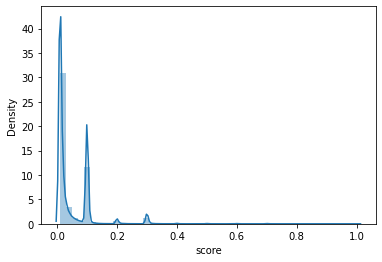

In [15]:
import seaborn as sns, numpy as np
ax = sns.distplot(df_full["score"])